In [1]:
import numpy as np
import pandas as pd
import xarray as xr
import scipy as sc

from scipy import linalg
from scipy.stats import rv_continuous, norm, pearson3, beta

import statsmodels.api as sm
from patsy import dmatrices
# from sklearn.linear_model import QuantileRegressor

import matplotlib.pyplot as plt

import sys
sys.path.append('..')
import utils, attrs

In [2]:
d = utils.load_tide_gauges_dict()
gauges = ['Stockholm', 'La Jolla, CA', 'Pago Pago', 'Santa Cruz']

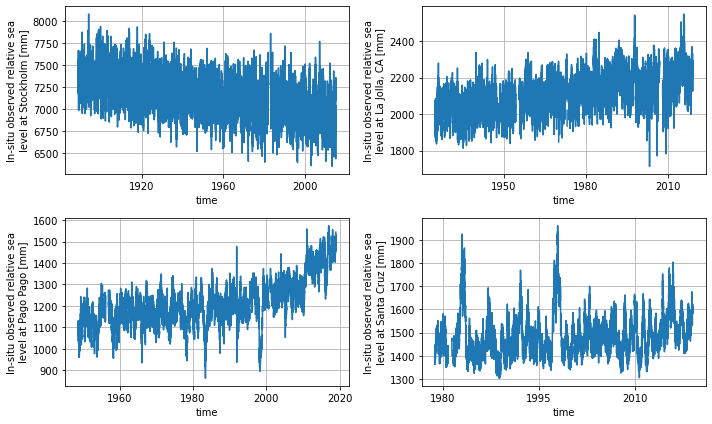

In [3]:
fig, axes = plt.subplots(figsize=(10,6), nrows=2, ncols=2)
axes = axes.ravel()
for i, gauge in enumerate(gauges):
    d[gauge].sea_level.plot(ax=axes[i])
    axes[i].grid()

fig.tight_layout()

In [8]:
## Preprocessing stuff
# gauge = 'Stockholm'
gauge = 'La Jolla, CA'
# gauge = 'Pago Pago'
# gauge = 'Santa Cruz'
# gauge = 'Wellington'
# gauge = 'New York, NY'

timeseries = d[gauge].sea_level
time = d[gauge].time
timeindex = np.arange(0, len(d[gauge].time))
df = timeseries.to_dataframe().reset_index()
df['time_index'] = timeindex
df = df[['time_index', 'sea_level']]
y, x = dmatrices('sea_level ~ timeindex', data=df, return_type='dataframe')

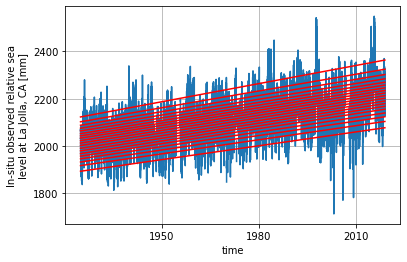

In [5]:
## Perform quantile regression for a each quantile and plot data
qr = sm.regression.quantile_regression.QuantReg(y, x) 
qs = np.arange(0.05, 1.0, 0.05)
quantile_changes = np.zeros_like(qs)

timeseries.plot()

for i, q in enumerate(qs):
    result = qr.fit(q=q)
    prediction = result.predict(x)
    plt.plot(time[prediction.index], prediction, color='r')
    quantile_changes[i] = (
        365 * 
        (np.array(result.predict(x))[-1] - np.array(result.predict(x))[0]) /
        (x['timeindex'].iloc[-1] - x['timeindex'].iloc[0])
    )
plt.grid()

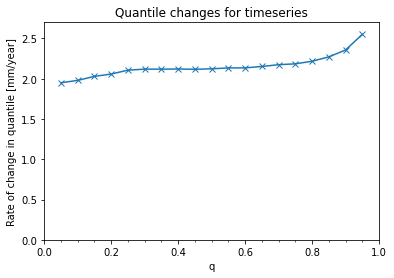

In [7]:
fig, ax = plt.subplots()
ax.plot(qs, quantile_changes, marker='x')

# Set xticklabels
xtickmajor = np.arange(0, 1.2, 0.2)
xtickminor = np.arange(0, 1.05, 0.05)

ax.set(
    title='Quantile changes for timeseries',
    xlabel='q',
    ylabel='Rate of change in quantile [mm/year]',
    ylim=(0,2.7),
);

ax.set_xticks(xtickmajor);
ax.set_xticks(xtickminor, minor=True);

In [10]:
# A = np.zeros((len(qs), 4))
# basis_functions = attrs.moment_basis_functions
# A[:,0] = basis_functions['mean']
# A[:,1] = basis_functions['var']
# A[:,2] = basis_functions['skew']
# A[:,3] = basis_functions['kurtosis']
A = utils.compute_basis_matrix('moments')
coeffs = linalg.lstsq(A, quantile_changes)[0]
print(coeffs)
weights = coeffs**2 / linalg.norm(coeffs)**2

print('weights:', np.array2string(weights, precision=3, suppress_small=True))

[2.1626603  0.46209878 0.24068378 0.28392305]
weights: [0.93  0.042 0.012 0.016]


In [11]:
# Same thing with legendre basis
A_leg = utils.compute_basis_matrix('legendre')
coeffs_leg = linalg.lstsq(A_leg, quantile_changes)[0]
weights_leg = coeffs_leg**2 / linalg.norm(coeffs_leg)**2
print(np.array2string(weights_leg, precision=3, suppress_small=True))

[0.966 0.018 0.009 0.006]


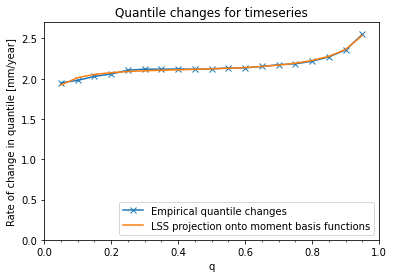

In [13]:
fig, ax = plt.subplots()
ax.plot(qs, quantile_changes, marker='x',
        label='Empirical quantile changes')
ax.plot(qs, A@coeffs, label='LSS projection onto moment basis functions')
# ax.plot(qs, A_leg@coeffs_leg, label='LSS projection onto legendre basis functions')
ax.set(
    title='Quantile changes for timeseries',
    xlabel='q',
    ylabel='Rate of change in quantile [mm/year]',
    ylim=(0,2.7),
);

ax.set_xticks(xtickmajor);
ax.set_xticks(xtickminor, minor=True);

ax.legend(loc='lower right')